In [41]:
import torch
import torchaudio
import numpy as np
from scipy.io import wavfile

print(torch.__version__)
print(torchaudio.__version__)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

2.1.1+cu121
2.1.0+cu121
cuda


In [42]:
from dataclasses import dataclass

import IPython
import matplotlib.pyplot as plt

torch.random.manual_seed(0)

SPEECH_FILE = "/speech/dbwork/mul/spielwiese4/students/desengus/phoneme_recognition/tmp_song/Adele-Hello-vocals-F minor-59bpm-441hz_1.wav"

In [43]:
def mono_downmix(audio):
    if np.shape(audio)[1] is not None:
        audio = np.mean(audio, axis=1)
    return audio

In [44]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()
with torch.inference_mode():
    waveform, sample_rate = torchaudio.load(SPEECH_FILE)
    # waveform = mono_downmix(waveform.numpy())
    emissions, _ = model(torch.tensor(waveform).to(device))
    emissions = torch.log_softmax(emissions, dim=-1)

emission = emissions[0].cpu().detach()

print(labels)

/tmp/ipykernel_1070577/280487111.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emissions, _ = model(torch.tensor(waveform).to(device))


('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [75]:
emmission = emission.numpy()
emission.shape

torch.Size([999, 29])

In [45]:
waveform = wavfile.read(SPEECH_FILE)[1]

In [46]:
import whisper
model = whisper.load_model("small.en", device=device)
result = whisper.transcribe(model = model , audio = waveform)


In [47]:
result

{'text': " Everything, they say the time's supposed to heal ya, but I ain't done much healing. Hello, can you hear me? I'm in California dreaming about her.",
 'segments': [{'id': 0,
   'seek': 0,
   'start': 0.0,
   'end': 10.0,
   'text': " Everything, they say the time's supposed to heal ya, but I ain't done much healing.",
   'tokens': [50363,
    11391,
    11,
    484,
    910,
    262,
    640,
    338,
    4385,
    284,
    12035,
    21349,
    11,
    475,
    314,
    18959,
    470,
    1760,
    881,
    11516,
    13,
    50863],
   'temperature': 0.0,
   'avg_logprob': -0.3526464643932524,
   'compression_ratio': 1.2083333333333333,
   'no_speech_prob': 0.025436362251639366},
  {'id': 1,
   'seek': 0,
   'start': 10.0,
   'end': 15.0,
   'text': ' Hello, can you hear me?',
   'tokens': [50863, 18435, 11, 460, 345, 3285, 502, 30, 51113],
   'temperature': 0.0,
   'avg_logprob': -0.3526464643932524,
   'compression_ratio': 1.2083333333333333,
   'no_speech_prob': 0.025436

In [64]:
import re
transcript = re.sub(r'[^\w\s]', '', result['text'].upper())

In [65]:
transcript = "|"+transcript.replace(' ', '|').replace('\n', '|')+"|"
transcript

'||EVERYTHING|THEY|SAY|THE|TIMES|SUPPOSED|TO|HEAL|YA|BUT|I|AINT|DONE|MUCH|HEALING|HELLO|CAN|YOU|HEAR|ME|IM|IN|CALIFORNIA|DREAMING|ABOUT|HER|'

In [66]:
# We enclose the transcript with space tokens, which represent SOS and EOS.
# transcript = "|I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|"

dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    trellis = torch.zeros((num_frame, num_tokens))
    trellis[1:, 0] = torch.cumsum(emission[1:, blank_id], 0)
    trellis[0, 1:] = -float("inf")
    trellis[-num_tokens + 1 :, 0] = float("inf")

    for t in range(num_frame - 1):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens[1:]],
        )
    return trellis


trellis = get_trellis(emission, tokens)

[('|', 1), ('|', 1), ('E', 2), ('V', 22), ('E', 2), ('R', 10), ('Y', 19), ('T', 3), ('H', 8), ('I', 7), ('N', 6), ('G', 18), ('|', 1), ('T', 3), ('H', 8), ('E', 2), ('Y', 19), ('|', 1), ('S', 9), ('A', 4), ('Y', 19), ('|', 1), ('T', 3), ('H', 8), ('E', 2), ('|', 1), ('T', 3), ('I', 7), ('M', 14), ('E', 2), ('S', 9), ('|', 1), ('S', 9), ('U', 13), ('P', 20), ('P', 20), ('O', 5), ('S', 9), ('E', 2), ('D', 11), ('|', 1), ('T', 3), ('O', 5), ('|', 1), ('H', 8), ('E', 2), ('A', 4), ('L', 12), ('|', 1), ('Y', 19), ('A', 4), ('|', 1), ('B', 21), ('U', 13), ('T', 3), ('|', 1), ('I', 7), ('|', 1), ('A', 4), ('I', 7), ('N', 6), ('T', 3), ('|', 1), ('D', 11), ('O', 5), ('N', 6), ('E', 2), ('|', 1), ('M', 14), ('U', 13), ('C', 16), ('H', 8), ('|', 1), ('H', 8), ('E', 2), ('A', 4), ('L', 12), ('I', 7), ('N', 6), ('G', 18), ('|', 1), ('H', 8), ('E', 2), ('L', 12), ('L', 12), ('O', 5), ('|', 1), ('C', 16), ('A', 4), ('N', 6), ('|', 1), ('Y', 19), ('O', 5), ('U', 13), ('|', 1), ('H', 8), ('E', 2), ('A

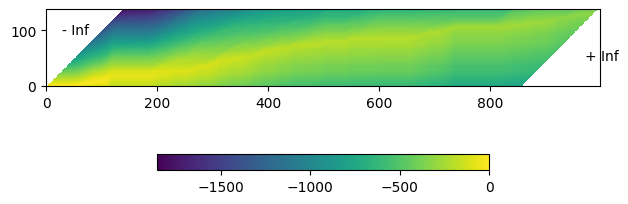

In [67]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(trellis.T, origin="lower")
    ax.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
    ax.annotate("+ Inf", (trellis.size(0) - trellis.size(1) / 5, trellis.size(1) / 3))
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

In [68]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float

    
def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        # Should not happen but just in case
        assert t > 0

        # 1. Figure out if the current position was stay or change
        # Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        # Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        # Update position
        t -= 1
        if changed > stayed:
            j -= 1

        # Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    # Now j == 0, which means, it reached the SoS.
    # Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

Point(token_index=0, time_index=0, score=0.9999984502792358)
Point(token_index=0, time_index=1, score=0.9999984502792358)
Point(token_index=0, time_index=2, score=0.9999984502792358)
Point(token_index=0, time_index=3, score=0.9999986886978149)
Point(token_index=0, time_index=4, score=0.9999990463256836)
Point(token_index=0, time_index=5, score=0.9999991655349731)
Point(token_index=0, time_index=6, score=0.999998927116394)
Point(token_index=0, time_index=7, score=0.9999990463256836)
Point(token_index=0, time_index=8, score=0.9999990463256836)
Point(token_index=0, time_index=9, score=0.9999985694885254)
Point(token_index=0, time_index=10, score=0.9999986886978149)
Point(token_index=0, time_index=11, score=0.9999939203262329)
Point(token_index=0, time_index=12, score=0.9999991655349731)
Point(token_index=0, time_index=13, score=0.9999991655349731)
Point(token_index=0, time_index=14, score=0.9999991655349731)
Point(token_index=0, time_index=15, score=0.9999939203262329)
Point(token_index=0

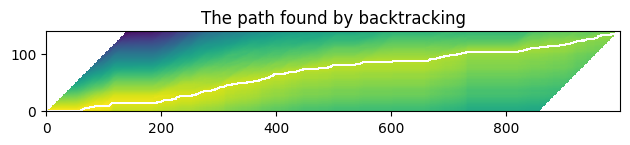

In [69]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path.T, origin="lower")
    plt.title("The path found by backtracking")
    plt.tight_layout()


plot_trellis_with_path(trellis, path)

In [76]:
# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

|	(0.98): [    0,    60)
|	(0.94): [   60,    61)
E	(1.00): [   61,    64)
V	(0.98): [   64,    67)
E	(0.73): [   67,    70)
R	(0.83): [   70,    76)
Y	(0.97): [   76,    82)
T	(0.87): [   82,    84)
H	(1.00): [   84,    96)
I	(0.54): [   96,   111)
N	(0.00): [  111,   112)
G	(0.97): [  112,   113)
|	(0.00): [  113,   114)
T	(0.00): [  114,   115)
H	(0.93): [  115,   193)
E	(0.94): [  193,   195)
Y	(0.89): [  195,   201)
|	(0.85): [  201,   205)
S	(0.97): [  205,   215)
A	(0.98): [  215,   219)
Y	(0.88): [  219,   224)
|	(0.30): [  224,   226)
T	(0.26): [  226,   227)
H	(0.77): [  227,   229)
E	(0.96): [  229,   232)
|	(0.70): [  232,   235)
T	(0.99): [  235,   254)
I	(0.91): [  254,   259)
M	(0.93): [  259,   261)
E	(0.66): [  261,   265)
S	(0.99): [  265,   266)
|	(0.63): [  266,   269)
S	(0.86): [  269,   273)
U	(0.48): [  273,   274)
P	(0.99): [  274,   278)
P	(0.99): [  278,   288)
O	(0.98): [  288,   294)
S	(0.89): [  294,   296)
E	(0.50): [  296,   298)
D	(0.95): [  298,   300)


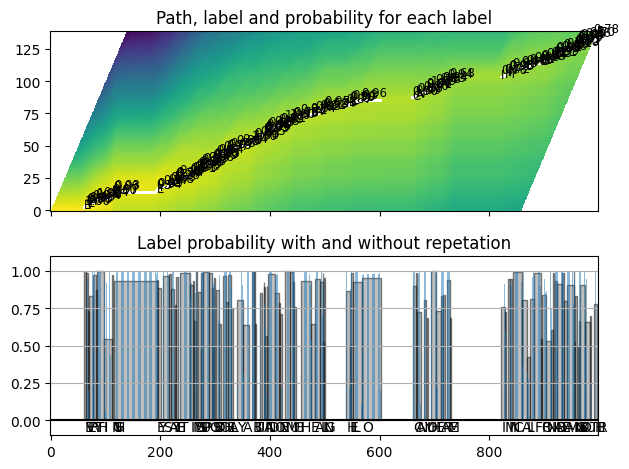

In [71]:
def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07))
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.grid(True, axis="y")
    ax2.set_ylim(-0.1, 1.1)
    fig.tight_layout()


plot_trellis_with_segments(trellis, segments, transcript)

In [72]:
segments

[|	(0.98): [    0,    60),
 |	(0.94): [   60,    61),
 E	(1.00): [   61,    64),
 V	(0.98): [   64,    67),
 E	(0.73): [   67,    70),
 R	(0.83): [   70,    76),
 Y	(0.97): [   76,    82),
 T	(0.87): [   82,    84),
 H	(1.00): [   84,    96),
 I	(0.54): [   96,   111),
 N	(0.00): [  111,   112),
 G	(0.97): [  112,   113),
 |	(0.00): [  113,   114),
 T	(0.00): [  114,   115),
 H	(0.93): [  115,   193),
 E	(0.94): [  193,   195),
 Y	(0.89): [  195,   201),
 |	(0.85): [  201,   205),
 S	(0.97): [  205,   215),
 A	(0.98): [  215,   219),
 Y	(0.88): [  219,   224),
 |	(0.30): [  224,   226),
 T	(0.26): [  226,   227),
 H	(0.77): [  227,   229),
 E	(0.96): [  229,   232),
 |	(0.70): [  232,   235),
 T	(0.99): [  235,   254),
 I	(0.91): [  254,   259),
 M	(0.93): [  259,   261),
 E	(0.66): [  261,   265),
 S	(0.99): [  265,   266),
 |	(0.63): [  266,   269),
 S	(0.86): [  269,   273),
 U	(0.48): [  273,   274),
 P	(0.99): [  274,   278),
 P	(0.99): [  278,   288),
 O	(0.98): [  288,   294),
 

In [1]:
from transformers import BertTokenizer, BertModel


/speech/dbwork/mul/spielwiese4/students/desengus/miniconda3/envs/dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)


In [3]:
tokenizer("sentence \n", return_tensors='pt', max_length=100, truncation=True, padding='max_length')

{'input_ids': tensor([[ 101, 6251,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [7]:
tokenizer("sentence #", return_tensors='pt', max_length=100, truncation=True, padding='max_length')

{'input_ids': tensor([[ 101, 6251, 1001,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,